In [1]:
import time
import math
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

In [2]:
pd.set_option("display.max_colwidth", 500)

In [3]:
PROJECT_DIR = Path().cwd().parent.parent
DATA_DIR = PROJECT_DIR / "data"

In [143]:
Path(DATA_DIR / "index.pdf").exists()

True

In [4]:
class ProcessData():
    def __init__(self):
        pass

    def read_file(self, file: str):
        """Takes a filename(excel or csv), Returns a pandas dataframe object."""
        if file.name.rsplit(sep=".")[-1] in ["xlsx", "xls"]:
            df = pd.read_excel(file)
        elif file.name.rsplit(sep=".")[-1] in ["csv"]:
            df = pd.read_csv(file)
    
        return df
    
    # def get_user_and_items(self, dataframe, user_col: str, item_col: str):
    #     """Takes a dataframe containing user-item interactions, Returns item list purchased by each user."""
    #     user_and_items = {}
    #     for name, group in df.loc[:,[user_col, item_col]].groupby(by=user_col):
    #         user_and_items.update({name:group.loc[:,item_col].to_list()})

    #     return user_and_items

    def transform_text_data(self, corpus: list):
        """Takes a list of tokens, Returns tf-idf vectors and the transformer object used in vectorization."""
        pipe = Pipeline([
                    ("count", CountVectorizer(
                                ngram_range=(1,1), 
                                token_pattern=r"[a-zA-Z0-9ıIiİğĞçÇöÖüÜşŞ]+", 
                                strip_accents="unicode",
                                lowercase=True)),
                    ("tfidf", TfidfTransformer())
                ])
        
        return pipe.fit_transform(corpus), pipe

    def compute_similarity(self, first: list, second: list):
        """Takes two array of numbers, Returns cosine similarity score between these two arrays."""
        from numpy.linalg import norm
        similarity_score = np.dot(first, second)/(norm(first)*norm(second))
        # from sklearn.metrics.pairwise import cosine_similarity
        # cosine_similarity(first.reshape(1,-1), second.reshape(1,-1))
        return similarity_score

processor = ProcessData()

In [119]:
class BuildGraph():
    def __init__(self):
        pass
    
    def build_graph(self, dataframe, tfidf):
        """Takes a dataframe and a tfidf matrix, Returns a Graph object."""        
        graph = networkx.Graph(label="item")
        start_time = time.time()
        for i, rowi in df.iterrows():
            if (i%1000 == 0):
                print(" iter {} -- {} seconds --".format(i, time.time()-start_time))
            graph.add_node(rowi["ITEM_NAME"], key=rowi["ITEM"], label="ITEM_NAME")
            graph.add_node(rowi["USER"], label="USER")
            graph.add_edge(rowi["ITEM_NAME"], rowi["USER"], label="Purchased")

            # graph.add_node(rowi["Clusters"], label="CLUSTERS")    
            # graph.add_edge(rowi["ITEM_NAME"], rowi["Clusters"], label="Belongs_To")

            s_node = "Similar ({})".format(rowi["ITEM_NAME"][:25].strip())
            graph.add_node(s_node, label="SIMILAR")
            graph.add_edge(rowi["ITEM_NAME"], s_node, label="Similarity")
            indices = self._find_similar(tfidf, i, top_n=25)
            for idx in indices:
                graph.add_edge(s_node, df["ITEM_NAME"].loc[idx], label="SIMILARITY")
        print(" finish -- {} seconds --".format(time.time() - start_time))

        return graph
    
    def _find_similar(self, tfidf_matrix, idx: int, top_n=25):
        """Takes a 2D array and an index, Returns similar arrays for that index."""
        from sklearn.metrics.pairwise import linear_kernel
        cosine_similarities = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()
        #sort the results in an ascending order, reverse it then ignore the first element at idx, take the rest top_n
        top_n_similar = cosine_similarities.argsort()[-2:-(top_n+2):-1].tolist()

        return top_n_similar

         
def get_recommendation(graph, node: str):
    """"Takes a Graph object and a root node, Returns a Series object containin Recommendations for that node."""
    common_items = dict(list())
    for n1 in graph.neighbors(node):
        for n2 in graph.neighbors(n1):
            if n2 == node:
                continue
            if graph.nodes[n2]['label']=="ITEM_NAME":
                if common_items.get(n2, -1) == -1:
                    common_items.update({n2: [n1]})
                elif common_items.get(n2, -1):
                    common_items[n2].append(n1)
    items=[]
    weight=[]
    for key, values in common_items.items():
        w=0.0
        for e in values:
            # Adamic Adar measure
            w += 1/math.log(graph.degree(e))
        items.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=items)
    result.sort_values(inplace=True, ascending=False)

    return result

def recommend(graph, node: list):
    import random
    # random.seed(100)
    item_and_similar = {}
    results = []
    for item in node:
        item_and_similar.update({item: get_recommendation(graph, item)})

    for similar_items in item_and_similar.values():
        results.extend(similar_items.index[:10].values)
    
    return random.sample(set(x),10)

def optional_clustering(dataframe, data_to_be_clustered, n_cluster=200):
    from sklearn.cluster import MiniBatchKMeans
    kmeans = MiniBatchKMeans(n_clusters=n_cluster, random_state=10)
    kmeans.fit(data_to_be_clustered)
    dataframe["Clusters"] = kmeans.predict(data_to_be_clustered)

    return dataframe

graph_builder = BuildGraph()      
# optional_clustering(df, tfidf, n_cluster=200)

In [9]:
file_name = "generic_rec_dataset_Ekim_New_data.xlsx"
file_path = DATA_DIR / file_name
df = processor.read_file(file_path)


In [10]:
# df.loc[:, ["USER", "ITEM"]].groupby(by="USER").count().sort_values(by="ITEM", ascending=False).reset_index()
user_ids = df.loc[:, "USER"].unique()
item_ids = df.loc[:, "ITEM"].unique()
print("Number of Users: {users}\nNumber of items: {items}".format(users=len(user_ids), items=len(item_ids)))

item_title = df.loc[:, "ITEM_NAME"]
tfidf, transformer = processor.transform_text_data(item_title)
vocabulary = transformer.steps[0][1].get_feature_names()
print("Tfidf vector shape: {}\nTfidf vocab size: {}".format(tfidf.shape, len(vocabulary)))

# similarity_score = processor.compute_similarity(tfidf.toarray()[1], tfidf.toarray()[2])
# similarity_score
# np.where(transformer.steps[0][1].fit_transform(item_title).toarray()[0]

Number of Users: 97
Number of items: 465
Tfidf vector shape: (6014, 997)
Tfidf vocab size: 997


In [11]:
graph = graph_builder.build_graph(df, tfidf)

 iter 0 -- 0.0010030269622802734 seconds --
 iter 1000 -- 1.2333178520202637 seconds --
 iter 2000 -- 2.321208953857422 seconds --
 iter 3000 -- 3.4381799697875977 seconds --
 iter 4000 -- 4.567582607269287 seconds --
 iter 5000 -- 5.706575870513916 seconds --
 iter 6000 -- 6.868666887283325 seconds --
 finish -- 6.884784698486328 seconds --


In [125]:
x = recommend(graph, ["Dijital Dönüşüme Giriş"])
# x.get("Dijital Dönüşümün Temelleri Gelişim Yolculuğu'na Hoş Geldin").head(10)
# x.get("Dijital Dönüşüme Giriş").head(10)
x


['Dijital Dönüşüm Kavramları',
 'Vuca - Okuma Materyali',
 'Dijital Dönüşümün Kurumlara Etkisi - Okuma Materyali',
 'Üssel Büyüyen Şirketler - Okuma Materyali',
 'Boz ya da Bozul',
 'Yıkıcı Yenilik - Video',
 'Dijital Girdap - Video',
 'Yıkıcı İş Modelleri - Video',
 'Dijital Dönüşüme Giriş',
 'Vuca Dünyası']

In [12]:
result = get_recommendation(graph, "Dijital Dönüşüme Giriş")
result2 = get_recommendation(graph, "Dijital Dönüşümün Temelleri Gelişim Yolculuğu'na Hoş Geldin")
result3 = get_recommendation(graph, "İK Departmanları İçin Kişisel Verilerin Korunması Kanunu")
result4 = get_recommendation(graph, "Detaylarıyla Kişisel Verilerin Korunması Kanunu")
print("*"*40+"\n Recommendation for --Dijital Dönüşüme Giriş--\n"+"*"*40)
print(result.head(10))
print("*"*40+"\n Recommendation for --Dijital Dönüşümün Temelleri Gelişim Yolculuğu'na Hoş Geldin--\n"+"*"*40)
print(result2.head(10))
print("*"*40+"\n Recommendation for --İK Departmanları İçin Kişisel Verilerin Korunması Kanunu--\n"+"*"*40)
print(result3.head(10))
print("*"*40+"\n Recommendation for --Detaylarıyla Kişisel Verilerin Korunması Kanunu--\n"+"*"*40)
print(result4.head(10))

****************************************
 Recommendation for --Dijital Dönüşüme Giriş--
****************************************
Değer Odaklı Strateji - Yıkıcı Yenilik - Okuma Materyali    20.944521
Boz ya da Bozul                                             20.944521
Dijital Dönüşümün Sektörler Üzerinde Etkileri - Video       20.944521
Dijital Dönüşümün Kurumlara Etkisi - Okuma Materyali        20.944521
Dijital Girdap - Video                                      20.510226
Yıkıcı Yenilik - Video                                      20.510226
Dijital Yanıt Stratejileri - Video                          20.131303
Yıkıcı İş Modelleri - Video                                 20.131303
Dijital Dünyada Rekabet - Video                             20.131303
Müşteri Deneyiminin Dijital Dönüşümü                        20.131303
dtype: float64
****************************************
 Recommendation for --Dijital Dönüşümün Temelleri Gelişim Yolculuğu'na Hoş Geldin--
*******************************

In [128]:
#To see what's going on,a sub-graph with only two movies ...¶
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in graph.neighbors(m):        
            sub_graph.add(e)
    return list(sub_graph)

def draw_sub_graph(sub_graph):
    subgraph = graph.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if graph.nodes[e]['label']=="ITEM_NAME":
            colors.append('blue')
        elif graph.nodes[e]['label']=="USER":
            colors.append('red')
        elif graph.nodes[e]['label']=="SIMILAR":
            colors.append('yellow')
        # elif graph.nodes[e]['label']=="CLUSTERS":
        #     colors.append('green')

    networkx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.style.use('seaborn')
    plt.rcParams['figure.figsize'] = [16,16]
    plt.show()

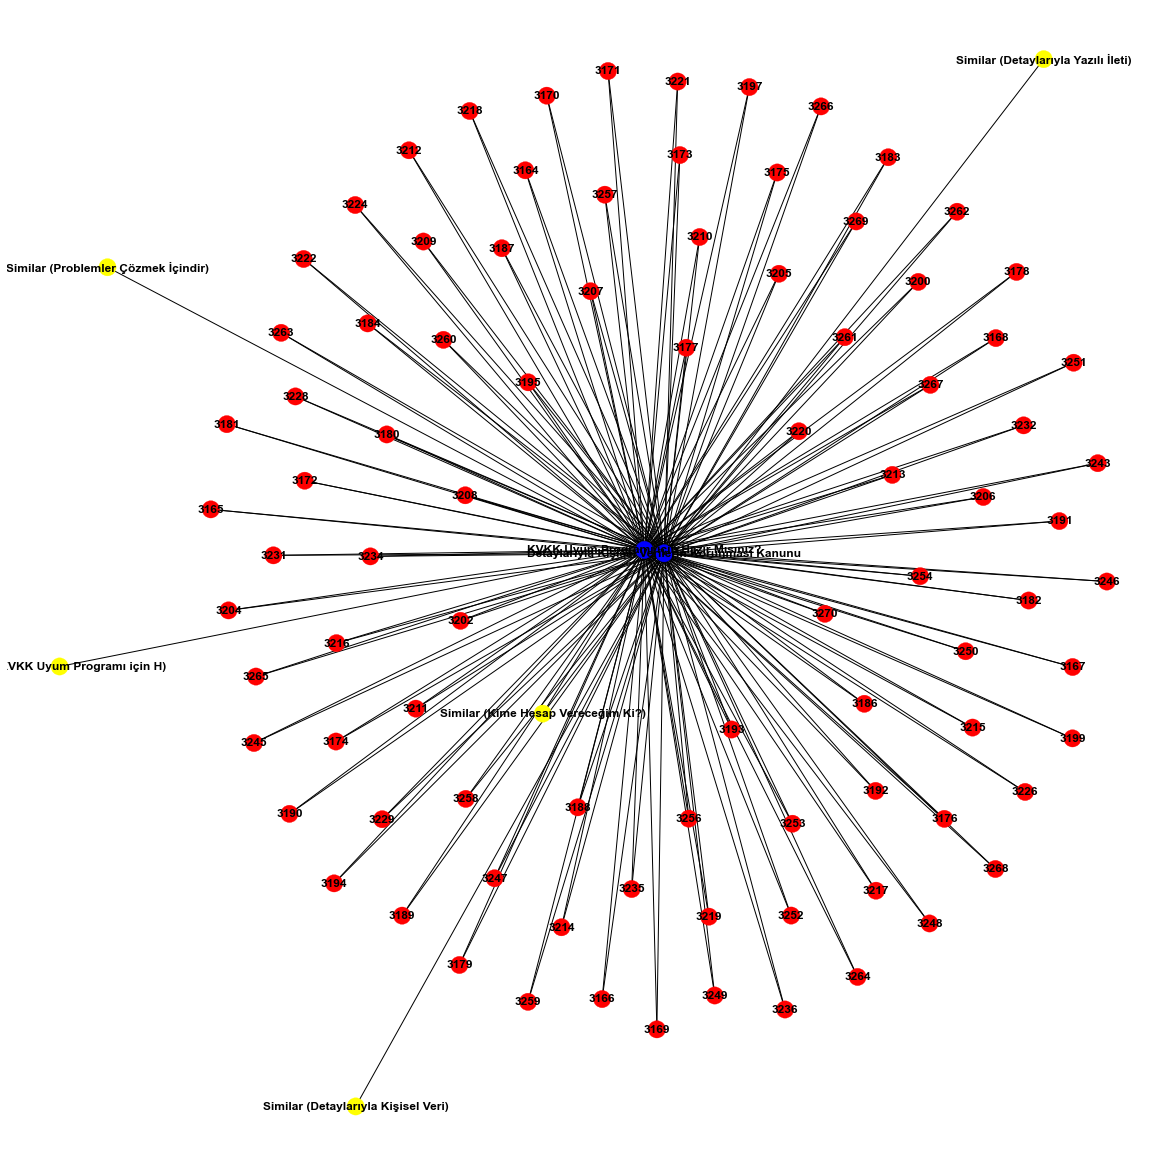

In [129]:
list_in=["KVKK Uyum Programı için Hazır Mısınız?", "Detaylarıyla Kişisel Verilerin Korunması Kanunu"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

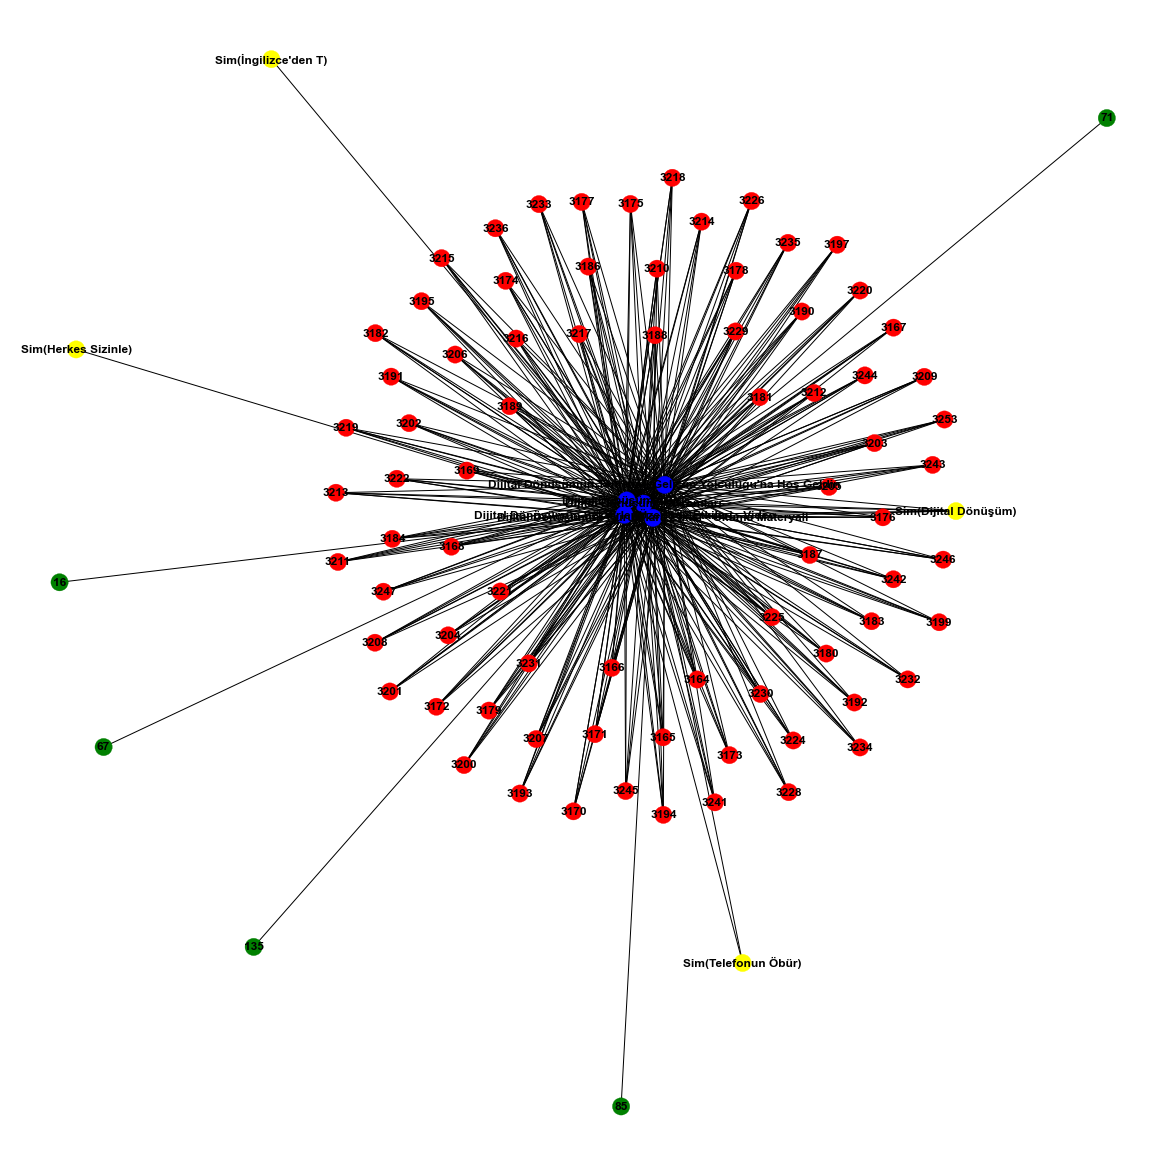

In [169]:
reco=list(result.index[:4].values)
reco.extend(["Dijital Dönüşüme Giriş"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

In [139]:
a = "asdasd"
a.split("*")

['asdasd']